In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

# Function to create DataFrame from search

In [3]:
def search_df(location, salary):
    '''Scrapes indeed.com search results into a dataframe'''
    df = pd.DataFrame()
    pd.set_option('max_colwidth', 500)
    
    base_url = 'http://www.indeed.com/jobs?q=data+scientist'
    sal_url = '&salary=' + salary
    loc_url = '&l=' + location
    end_url = '&jt=fulltime&sort=date&start='
    for page in range(1,41):
        page = (page-1) * 10
        url = "%s%s%s%s%d" % (base_url, sal_url, loc_url, end_url, page)

        contents = BeautifulSoup(requests.get(url).text, 'lxml')    

        contentsElements = contents.find_all('div', attrs={'class' : '  row  result'}) 

        for elem in contentsElements: 
            try:
                company = elem.find('span', attrs={'itemprop':'name'}).getText().strip()
            except AttributeError:
                company = '-'
            job_title = elem.find('a', attrs={'class':'turnstileLink'}).attrs['title']
            home_url = "http://www.indeed.com"
            job_link = "%s%s" % (home_url,elem.find('a').get('href'))
            job_addr = elem.find('span', attrs={'itemprop':'addressLocality'}).getText()
            job_posted = elem.find('span', attrs={'class': 'date'}).getText()
            description = elem.find('span', attrs={'class': 'summary'}).getText().strip()
            #try:
            #    salary = elem.find('nobr').getText()
            #except AttributeError:
            #    salary = None

            df = df.append({'company': company, 
                            'job_title': job_title, 
                            'job_link': job_link, 
                            #'job_posted': job_posted,
                            'job_location': job_addr,
                            #'salary': salary,
                            'description': description
                           }, ignore_index=True)

        lastElement = contents.find('div', attrs={'class' : 'lastRow  row  result'})
        try:
            company = lastElement.find('span', attrs={'itemprop':'name'}).getText().strip()
        except AttributeError:
            company = '-'
        job_title = lastElement.find('a', attrs={'class':'turnstileLink'}).attrs['title']
        home_url = "http://www.indeed.com"
        job_link = "%s%s" % (home_url,lastElement.find('a').get('href'))
        job_addr = lastElement.find('span', attrs={'itemprop':'addressLocality'}).getText()
        job_posted = lastElement.find('span', attrs={'class': 'date'}).getText()
        description = lastElement.find('span', attrs={'class': 'summary'}).getText().strip()
        #try:
        #    salary = lastElement.find('nobr').getText()
        #except AttributeError:
        #    salary = None

        df = df.append({'company': company, 
                        'job_title': job_title, 
                        'job_link': job_link, 
                        #'job_posted': job_posted,
                        'job_location': job_addr,
                        #'salary': salary,
                        'description': description
                        }, ignore_index=True)
    df['salary'] = salary
    return df.drop_duplicates()


# Function to search by salary bins and concat to larger dataframe

In [4]:
salary_bins = {1: '$65,000-$90,000',
               2: '$90,000-$110,000',
               3: '$110,000-$130,000',
               4: '$130,000'
               }

def make_bins(location):
    '''Creates a dataframe for each salary bin and concats into one big dataframe'''
    df1 = search_df(location, salary_bins[1])
    df2 = search_df(location, salary_bins[2])
    df3 = search_df(location, salary_bins[3])
    df4 = search_df(location, salary_bins[4])

    bigdf = pd.concat([df1,df2,df3,df4])
    
    inv_map = {v: k for k, v in salary_bins.items()}
    bigdf['salary_bins'] = bigdf.salary.map(inv_map)
    bigdf['location'] = location
    
    return bigdf
    bigdf.salary.value_counts()

sanfran_df = make_bins('san francisco')
sanjose_df = make_bins('san jose')
seattle_df = make_bins('seattle')
master_df = pd.concat([sanfran_df, sanjose_df, seattle_df])

In [5]:
sanfran_df.head(5)

,company,description,job_link,job_location,job_title,salary,salary_bins,location
0,Lawrence Berkeley National Laboratory,"These projects support reproducible and collaborative scientific computing and data science across a wide range of programming languages (Python, Julia, R, etc....",http://www.indeed.com/rc/clk?jk=c97265a6047fe880&fccid=5bee64c47451d1c2,"Berkeley, CA 94720",Postdoctoral Scholar,"$65,000-$90,000",1,san francisco
1,Kantar Millward Brown,"As a Client Analyst, you will design questionnaires, pull data, write reports, and understand how to tell a story from data....",http://www.indeed.com/rc/clk?jk=d694825a8618655a&fccid=a7907288a91c75a0,"San Francisco, CA",Market Research Client Analyst,"$65,000-$90,000",1,san francisco
2,Lawrence Berkeley National Laboratory,"Excellent communications skills and the desire to collaborate and work effectively within a multidisciplinary research team of scientists, engineers, and...",http://www.indeed.com/rc/clk?jk=6bbcc7fb07083e48&fccid=5bee64c47451d1c2,"Berkeley, CA 94720",Battery Project Scientist (Materials Sciences),"$65,000-$90,000",1,san francisco
3,Ocean Science Trust,"Act as a liaison between data providers (e.g., academic and government agency scientists, citizen scientists) and end users (e.g., stakeholders and government...",http://www.indeed.com/rc/clk?jk=f1d844a7825eba3c&fccid=d1df554d978164a6,"Oakland, CA 94612 (Northgate area)",Technology Initiatives Director,"$65,000-$90,000",1,san francisco
4,Genentech,"Collaborate with other scientists within the clinical imaging, research imaging, biomarker, biostatistics and clinical science groups on designing image...",http://www.indeed.com/rc/clk?jk=5887c1f9e9b5cdd7&fccid=2525cc4a9a704809,"South San Francisco, CA",Assistant Clinical Imaging Scientist,"$65,000-$90,000",1,san francisco


In [6]:
sanfran_df.duplicated(subset=['company', 'job_title', 'job_link', 'job_location', 'description']).value_counts()

False    1368
dtype: int64

In [7]:
sanfran_df.job_location.value_counts()[:15]

San Francisco, CA                                    471
Foster City, CA                                       73
South San Francisco, CA                               67
Redwood City, CA                                      66
San Francisco, CA 94105 (Financial District area)     48
South San Francisco, CA 94080                         45
San Francisco, CA 94103 (South Of Market area)        42
Berkeley, CA 94720                                    35
San Francisco, CA 94107 (South Of Market area)        34
Emeryville, CA                                        33
San Mateo, CA                                         32
San Bruno, CA 94066                                   27
San Ramon, CA                                         26
San Carlos, CA 94070                                  25
Berkeley, CA                                          24
Name: job_location, dtype: int64

# Logistic Regression on Job Title words

In [8]:
import sklearn.feature_extraction
import sklearn.linear_model
import sklearn.preprocessing
import nltk

def word_probs(df, column):
    tfidf = sklearn.feature_extraction.text.TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.6)
    X = tfidf.fit_transform(list(df[column]))
    
    logreg = sklearn.linear_model.LogisticRegression()
    logreg.fit(X,list(df.salary_bins))
        
    columns = ['word']
    word_list = []
    for word in tfidf.get_feature_names():
        word_list.append(word)
    word_df = pd.DataFrame(word_list, columns=columns)
    
    column_1 = []
    column_2 = []
    column_3 = []
    column_4 = []
    for word in word_df['word']:
        column_1.append(logreg.predict_proba(tfidf.transform([word]))[0][0])
        column_2.append(logreg.predict_proba(tfidf.transform([word]))[0][1])
        column_3.append(logreg.predict_proba(tfidf.transform([word]))[0][2])
        column_4.append(logreg.predict_proba(tfidf.transform([word]))[0][3])
    word_df[salary_bins[1]] = column_1
    word_df[salary_bins[2]] = column_2
    word_df[salary_bins[3]] = column_3
    word_df[salary_bins[4]] = column_4
    
    return word_df

In [9]:
sf_word = word_probs(sanfran_df, 'job_title')
seattle_word = word_probs(seattle_df, 'job_title')
sanjose_word = word_probs(sanjose_df, 'job_title')

In [10]:
sf_goodwords = sf_word.sort_values(by=salary_bins[4], ascending=False)[:15]
sf_badwords = sf_word.sort_values(by=salary_bins[1], ascending=False)[:15]

sf_goodwords

,word,"$65,000-$90,000","$90,000-$110,000","$110,000-$130,000","$130,000"
47,architect,0.146124,0.112127,0.127834,0.613915
502,platform,0.163947,0.168109,0.109626,0.558317
172,data,0.045128,0.100529,0.340595,0.513748
192,director,0.024634,0.102514,0.366612,0.506239
304,head,0.187996,0.171569,0.155062,0.485372
523,product,0.076988,0.207521,0.239853,0.475639
33,analytics,0.197895,0.226319,0.120741,0.455045
381,lead,0.097791,0.183800,0.286718,0.431691
385,learning,0.137262,0.182696,0.254382,0.425661
518,principal,0.067772,0.166959,0.349222,0.416047


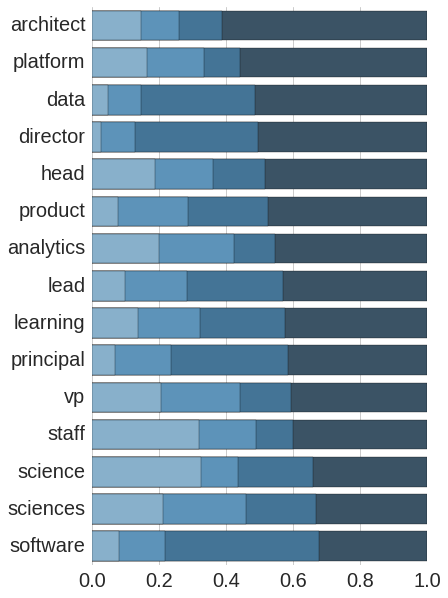

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2)

f, ax = plt.subplots(figsize=(6, 10))

sf_goodwords['y4'] = sf_goodwords[salary_bins[4]] + sf_goodwords[salary_bins[3]] + sf_goodwords[salary_bins[2]] + sf_goodwords[salary_bins[1]]
sf_goodwords['y3'] = sf_goodwords[salary_bins[3]] + sf_goodwords[salary_bins[2]] + sf_goodwords[salary_bins[1]]
sf_goodwords['y2'] = sf_goodwords[salary_bins[2]] + sf_goodwords[salary_bins[1]]
sf_goodwords['y1'] = sf_goodwords[salary_bins[1]]

color = sns.color_palette("Blues_d", 4)
sns.barplot(y="word", x='y4', data=sf_goodwords,
            label="$130,000", color=color[0])

sns.barplot(y="word", x='y3', data=sf_goodwords,
            label="$110,000-$130,000", color=color[1])

sns.barplot(y="word", x='y2', data=sf_goodwords,
            label="$90,000-$110,000", color=color[2])

sns.barplot(y="word", x='y1', data=sf_goodwords,
            label="$65,000-$90,000", color=color[3])

ax.set(xlim=(0, 1), ylabel="",
       xlabel="")
sns.despine(left=True, bottom=True)

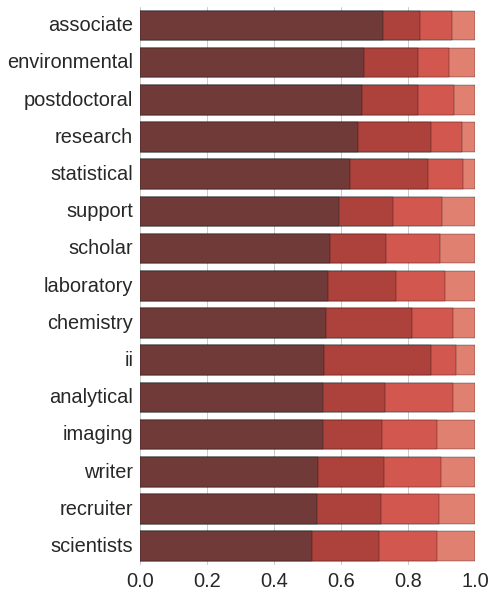

In [12]:
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2)

f, ax = plt.subplots(figsize=(6, 10))

sf_badwords['y4'] = sf_badwords[salary_bins[4]] + sf_badwords[salary_bins[3]] + sf_badwords[salary_bins[2]] + sf_badwords[salary_bins[1]]
sf_badwords['y3'] = sf_badwords[salary_bins[3]] + sf_badwords[salary_bins[2]] + sf_badwords[salary_bins[1]]
sf_badwords['y2'] = sf_badwords[salary_bins[2]] + sf_badwords[salary_bins[1]]
sf_badwords['y1'] = sf_badwords[salary_bins[1]]

color = sns.color_palette("Reds_d", 4)
sns.barplot(y="word", x='y4', data=sf_badwords,
            label="$130,000", color=color[3])

sns.barplot(y="word", x='y3', data=sf_badwords,
            label="$110,000-$130,000", color=color[2])

sns.barplot(y="word", x='y2', data=sf_badwords,
            label="$90,000-$110,000", color=color[1])

sns.barplot(y="word", x='y1', data=sf_badwords,
            label="$65,000-$90,000", color=color[0])

ax.set(xlim=(0, 1), ylabel="",
       xlabel="")
sns.despine(left=True, bottom=True)

In [13]:
seattle_word.sort_values(by=salary_bins[4], ascending=False)[:15]

,word,"$65,000-$90,000","$90,000-$110,000","$110,000-$130,000","$130,000"
367,principal,0.070071,0.157447,0.296867,0.475615
349,platform,0.132750,0.163861,0.244203,0.459186
138,director,0.090987,0.173170,0.336080,0.399763
285,manager,0.148497,0.187418,0.275607,0.388479
38,architect,0.212978,0.201745,0.202953,0.382325
461,sr,0.187049,0.253328,0.182504,0.377118
242,infrastructure,0.258012,0.229708,0.158899,0.353382
482,technical,0.197525,0.186353,0.285453,0.330668
34,applied,0.121136,0.203839,0.349107,0.325918
463,staff,0.349576,0.196867,0.136336,0.317221


In [14]:
sanjose_word.sort_values(by=salary_bins[4], ascending=False)[:15]

,word,"$65,000-$90,000","$90,000-$110,000","$110,000-$130,000","$130,000"
516,senior,0.103695,0.047507,0.324503,0.524295
595,ui,0.160666,0.144970,0.175403,0.518962
428,platform,0.144230,0.216902,0.126018,0.512851
156,data,0.047368,0.151051,0.298072,0.503509
176,director,0.051289,0.179342,0.324356,0.445014
39,analytics,0.238956,0.095213,0.238717,0.427114
126,computing,0.215554,0.199112,0.177122,0.408212
498,sales,0.287924,0.164068,0.142260,0.405749
204,engineering,0.197259,0.200614,0.206287,0.395840
48,applied,0.104889,0.238307,0.264528,0.392277


In [15]:
master_df.to_csv('./indeed_companies.csv', encoding='utf-8')

# LogReg on Job Description words

In [16]:
sf_descword = word_probs(sanfran_df, 'description')

In [17]:
sf_descgoodwords = sf_descword.sort_values(by=salary_bins[4], ascending=False)[:20]
sf_descbadwords = sf_descword.sort_values(by=salary_bins[1], ascending=False)[:20]
sf_descgoodwords

,word,"$65,000-$90,000","$90,000-$110,000","$110,000-$130,000","$130,000"
653,data,0.046808,0.041797,0.332036,0.579360
1503,learning,0.059177,0.143230,0.288609,0.508984
149,analytics,0.097944,0.219393,0.223149,0.459514
1716,models,0.228578,0.135645,0.182099,0.453679
1570,machine,0.053047,0.161425,0.351446,0.434083
1493,lead,0.248722,0.117436,0.260170,0.373672
2470,solutions,0.263678,0.142120,0.224310,0.369891
2054,product,0.133827,0.213405,0.291602,0.361165
1558,looking,0.267677,0.159336,0.213417,0.359571
2533,startup,0.258441,0.206709,0.179648,0.355203


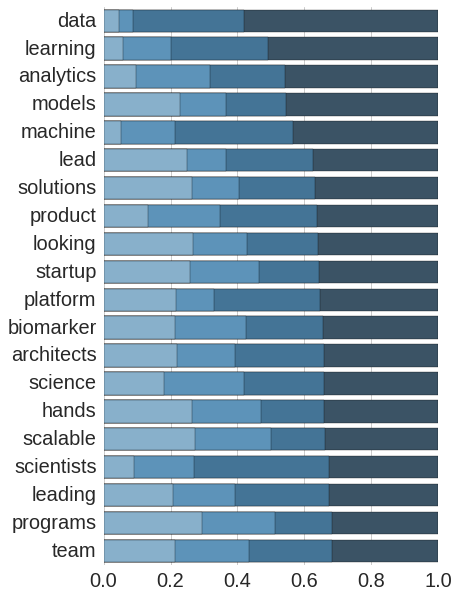

In [18]:
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2)

f, ax = plt.subplots(figsize=(6, 10))

sf_descgoodwords['y4'] = sf_descgoodwords[salary_bins[4]] + sf_descgoodwords[salary_bins[3]] + sf_descgoodwords[salary_bins[2]] + sf_descgoodwords[salary_bins[1]]
sf_descgoodwords['y3'] = sf_descgoodwords[salary_bins[3]] + sf_descgoodwords[salary_bins[2]] + sf_descgoodwords[salary_bins[1]]
sf_descgoodwords['y2'] = sf_descgoodwords[salary_bins[2]] + sf_descgoodwords[salary_bins[1]]
sf_descgoodwords['y1'] = sf_descgoodwords[salary_bins[1]]

color = sns.color_palette("Blues_d", 4)
sns.barplot(y="word", x='y4', data=sf_descgoodwords,
            label="$130,000", color=color[0])

sns.barplot(y="word", x='y3', data=sf_descgoodwords,
            label="$110,000-$130,000", color=color[1])

sns.barplot(y="word", x='y2', data=sf_descgoodwords,
            label="$90,000-$110,000", color=color[2])

sns.barplot(y="word", x='y1', data=sf_descgoodwords,
            label="$65,000-$90,000", color=color[3])

ax.set(xlim=(0, 1), ylabel="",
       xlabel="")
sns.despine(left=True, bottom=True)

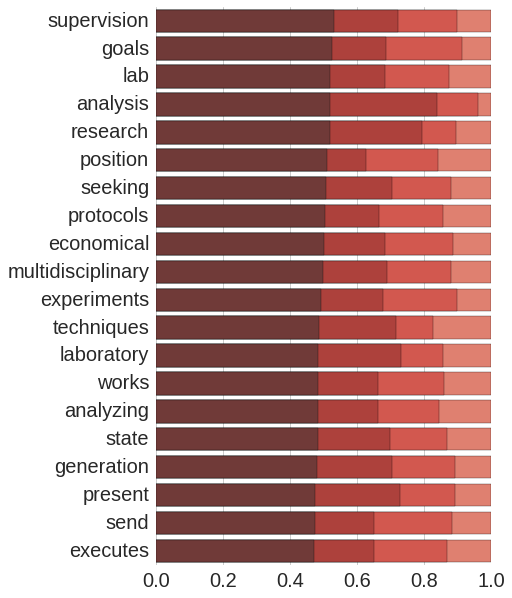

In [19]:
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2)

f, ax = plt.subplots(figsize=(6, 10))

sf_descbadwords['y4'] = sf_descbadwords[salary_bins[4]] + sf_descbadwords[salary_bins[3]] + sf_descbadwords[salary_bins[2]] + sf_descbadwords[salary_bins[1]]
sf_descbadwords['y3'] = sf_descbadwords[salary_bins[3]] + sf_descbadwords[salary_bins[2]] + sf_descbadwords[salary_bins[1]]
sf_descbadwords['y2'] = sf_descbadwords[salary_bins[2]] + sf_descbadwords[salary_bins[1]]
sf_descbadwords['y1'] = sf_descbadwords[salary_bins[1]]

color = sns.color_palette("Reds_d", 4)
sns.barplot(y="word", x='y4', data=sf_descbadwords,
            label="$130,000", color=color[3])

sns.barplot(y="word", x='y3', data=sf_descbadwords,
            label="$110,000-$130,000", color=color[2])

sns.barplot(y="word", x='y2', data=sf_descbadwords,
            label="$90,000-$110,000", color=color[1])

sns.barplot(y="word", x='y1', data=sf_descbadwords,
            label="$65,000-$90,000", color=color[0])

ax.set(xlim=(0, 1), ylabel="",
       xlabel="")
sns.despine(left=True, bottom=True)

# Distribution of Salaries by Location

In [20]:
from bokeh.charts import Bar, output_notebook, show
from bokeh.sampledata.autompg import autompg as df

p = Bar(master_df, label='salary_bins', values='job_title', agg='count', group='location',
        title="Distribution of Salary by City", legend='top_right', ylabel='Number of Jobs', xlabel='Salary')

output_notebook()

show(p)

Loading BokehJS ...

# Companies Hiring

In [21]:
print sanfran_df.company.nunique()
sanfran_df.company.value_counts()[0:10]

523


Uber                                     41
Lawrence Berkeley National Laboratory    35
Gilead Sciences                          31
Gilead                                   31
BioMarin Pharmaceutical Inc.             29
Genentech                                27
The Climate Corporation                  26
Walmart eCommerce                        25
Natera                                   24
Workbridge Associates                    19
Name: company, dtype: int64

In [22]:
print sanjose_df.company.nunique()
sanjose_df.company.value_counts()[0:10]

359


Apple                       40
Google                      35
Natera                      24
Walmart eCommerce           24
Facebook                    19
Amazon Corporate LLC        16
NVIDIA                      15
Quora                       13
Elevate Recruiting Group    13
Magic Leap, Inc.            13
Name: company, dtype: int64

In [23]:
print seattle_df.company.nunique()
seattle_df.company.value_counts()[0:10]

170


Amazon Corporate LLC                       241
Microsoft                                   73
University of Washington Medical Center     42
University of Washington                    35
Fred Hutchinson Cancer Research Center      17
CDK Global                                  17
Amazon Fulfillment Services, Inc.           13
Juno Therapeutics                           11
Physio-Control, Inc.                        10
Socrata                                      9
Name: company, dtype: int64

# Model

In [24]:
master_df.head(3)

,company,description,job_link,job_location,job_title,salary,salary_bins,location
0,Lawrence Berkeley National Laboratory,"These projects support reproducible and collaborative scientific computing and data science across a wide range of programming languages (Python, Julia, R, etc....",http://www.indeed.com/rc/clk?jk=c97265a6047fe880&fccid=5bee64c47451d1c2,"Berkeley, CA 94720",Postdoctoral Scholar,"$65,000-$90,000",1,san francisco
1,Kantar Millward Brown,"As a Client Analyst, you will design questionnaires, pull data, write reports, and understand how to tell a story from data....",http://www.indeed.com/rc/clk?jk=d694825a8618655a&fccid=a7907288a91c75a0,"San Francisco, CA",Market Research Client Analyst,"$65,000-$90,000",1,san francisco
2,Lawrence Berkeley National Laboratory,"Excellent communications skills and the desire to collaborate and work effectively within a multidisciplinary research team of scientists, engineers, and...",http://www.indeed.com/rc/clk?jk=6bbcc7fb07083e48&fccid=5bee64c47451d1c2,"Berkeley, CA 94720",Battery Project Scientist (Materials Sciences),"$65,000-$90,000",1,san francisco


In [137]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.cross_validation import cross_val_score

transformer = FeatureUnion([
                ('desc_tfidf', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['description'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(stop_words='english'))])),
                ('title_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['job_title'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(stop_words='english'))]))]) 

X_words = transformer.fit_transform(master_df[['description', 'job_title']])
X_loc = master_df['location']

X_words.shape # (3145, 5624)
X_loc.shape   # (3145, )
type(X_words) # <class 'scipy.sparse.csr.csr_matrix'>
type(X_loc)   # <class 'pandas.core.series.Series'>

logreg_model= sklearn.linear_model.LogisticRegression(max_iter=400)

params = {'penalty': ['l2'],
          'C': [4, 6, 8, 10, 12],
          'solver': ['liblinear', 'newton-cg', 'sag', 'lbfgs']}

from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(logreg_model, params, n_jobs=-1, cv=5)
grid.fit(X_words, master_df.salary_bins)

print grid.best_params_

def val_score(model, X, y, cv):
    #print model
    score = cross_val_score(model, X, y, cv=cv)
    mean = score.mean()
    std = score.std()
    print "Score: {:.3} +/- {:.3}".format(mean, std)

print val_score(grid, X_words, master_df.salary_bins, 5)



def df_maker(what):
    df = pd.DataFrame(what).T
    df.columns = ['description', 'job_title']
    return df

#print logreg_model.predict_proba(transformer.transform(df_maker(what)))

{'penalty': 'l2', 'C': 12, 'solver': 'liblinear'}
Score: 0.488 +/- 0.0434
None


In [138]:
tfidf = sklearn.feature_extraction.text.TfidfVectorizer(analyzer='word', stop_words='english')
    
logreg_title = sklearn.linear_model.LogisticRegression(max_iter=400)
params = {'penalty': ['l2'],
          'C': [4, 6, 8, 10, 12],
          'solver': ['liblinear', 'newton-cg', 'sag', 'lbfgs']}

grid2 = GridSearchCV(logreg_model, params, n_jobs=-1, cv=5)
grid2.fit(tfidf.fit_transform(master_df['job_title']), master_df.salary_bins)

print grid2.best_params_
val_score(grid2, tfidf.fit_transform(master_df['job_title']), master_df.salary_bins, 5)

{'penalty': 'l2', 'C': 4, 'solver': 'lbfgs'}
Score: 0.436 +/- 0.0319


## Link to presentation:
https://docs.google.com/presentation/d/175H92uM9L40ZyMQI1j4ai6c4fhsafJjCD5PpnhC9t6M/edit?usp=sharing